<a href="https://colab.research.google.com/github/gmkim71/CNN/blob/main/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
import numpy as np

import os
import pathlib

import cv2 #영상처리에 사용하는 오픈소스 라이브러리, 컴퓨터가 사람 눈처럼 인식할 수 있게 처리
from PIL import Image # 파이썬 이미지 처리 pillow 라이브러리
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #imagedatagenerater는 이미지를 학습시킬 때 학습 데이터의 양이 적을 경우 학습데이터를 조금씩 변형 시켜서 학습데이터의 양을 늘리는 방식중 하나
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')#그래프 스타일 지정

#난수 랜덤성 고정
np.random.seed(42)

%matplotlib inline

In [ ]:
if 'google.colab' in str(get_ipython()):
    # running on CoLab
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_directory = '/content/gdrive/MyDrive/'
    DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Mounted at /content/gdrive


In [ ]:
# 코렙은 좌측 파일 아이콘 클릭해서 마운팅된 파일 하나를 오른쪽 마우스 클릭하면 경로 카피할 수 있음
data_dir = pathlib.Path('/content/gdrive/MyDrive/archive/Meta')
train_path = pathlib.Path('/content/gdrive/MyDrive/archive/Train')
test_path = pathlib.Path('/content/gdrive/MyDrive/archive/Test')

# 전처리: 이미지 별로 사이즈가 다르기 때문에 이미지의 폭과 높이를 같은 크기로 통일
IMG_HEGHT = 30
IMG_WIDTH = 30
channels = 3

# 카테고리 수 확인
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

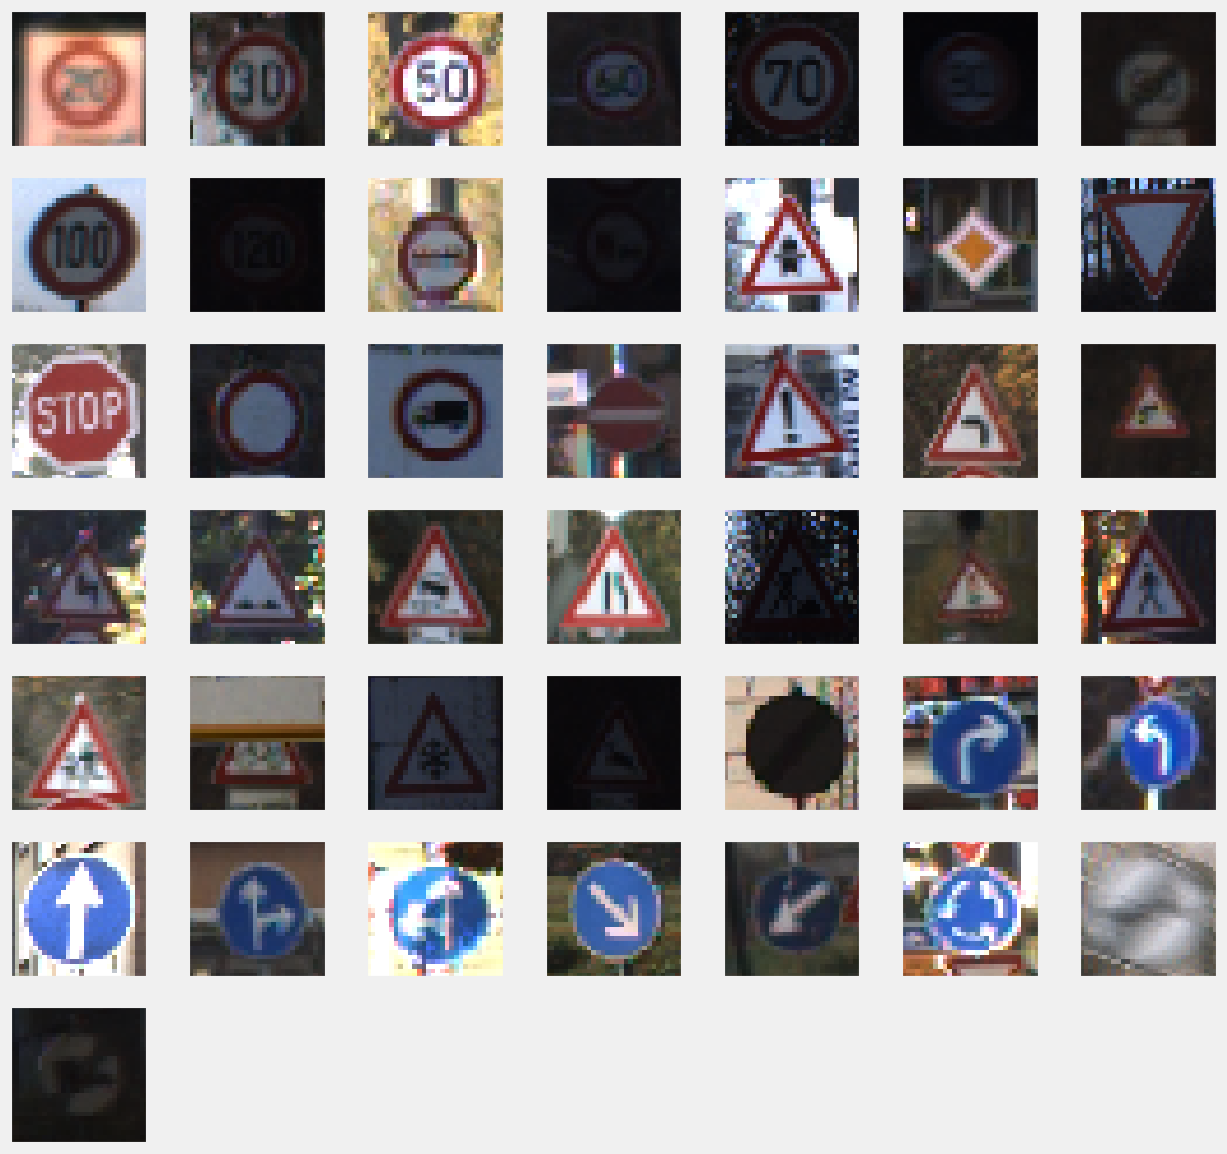

In [ ]:
# 모든 교통표시판 시각화

img_dir = pathlib.Path('/content/gdrive/MyDrive/archive/Train')
plt.figure(figsize=(14,14))
index = 0
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    plt.xticks([]) #눈금 설정 없음
    plt.yticks([])
    sign = list(img_dir.glob(f'{i}/*'))[0] #glob모듈의 glob함수는 사용자가 제시한 조건에 맞는 파일명을 리스트형식으로 반환 #*(아스터리스크)는 임의 길이의 모든 문자열을 의미
    img = load_img(sign, target_size=(30, 30))
    plt.imshow(img)
plt.show()

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

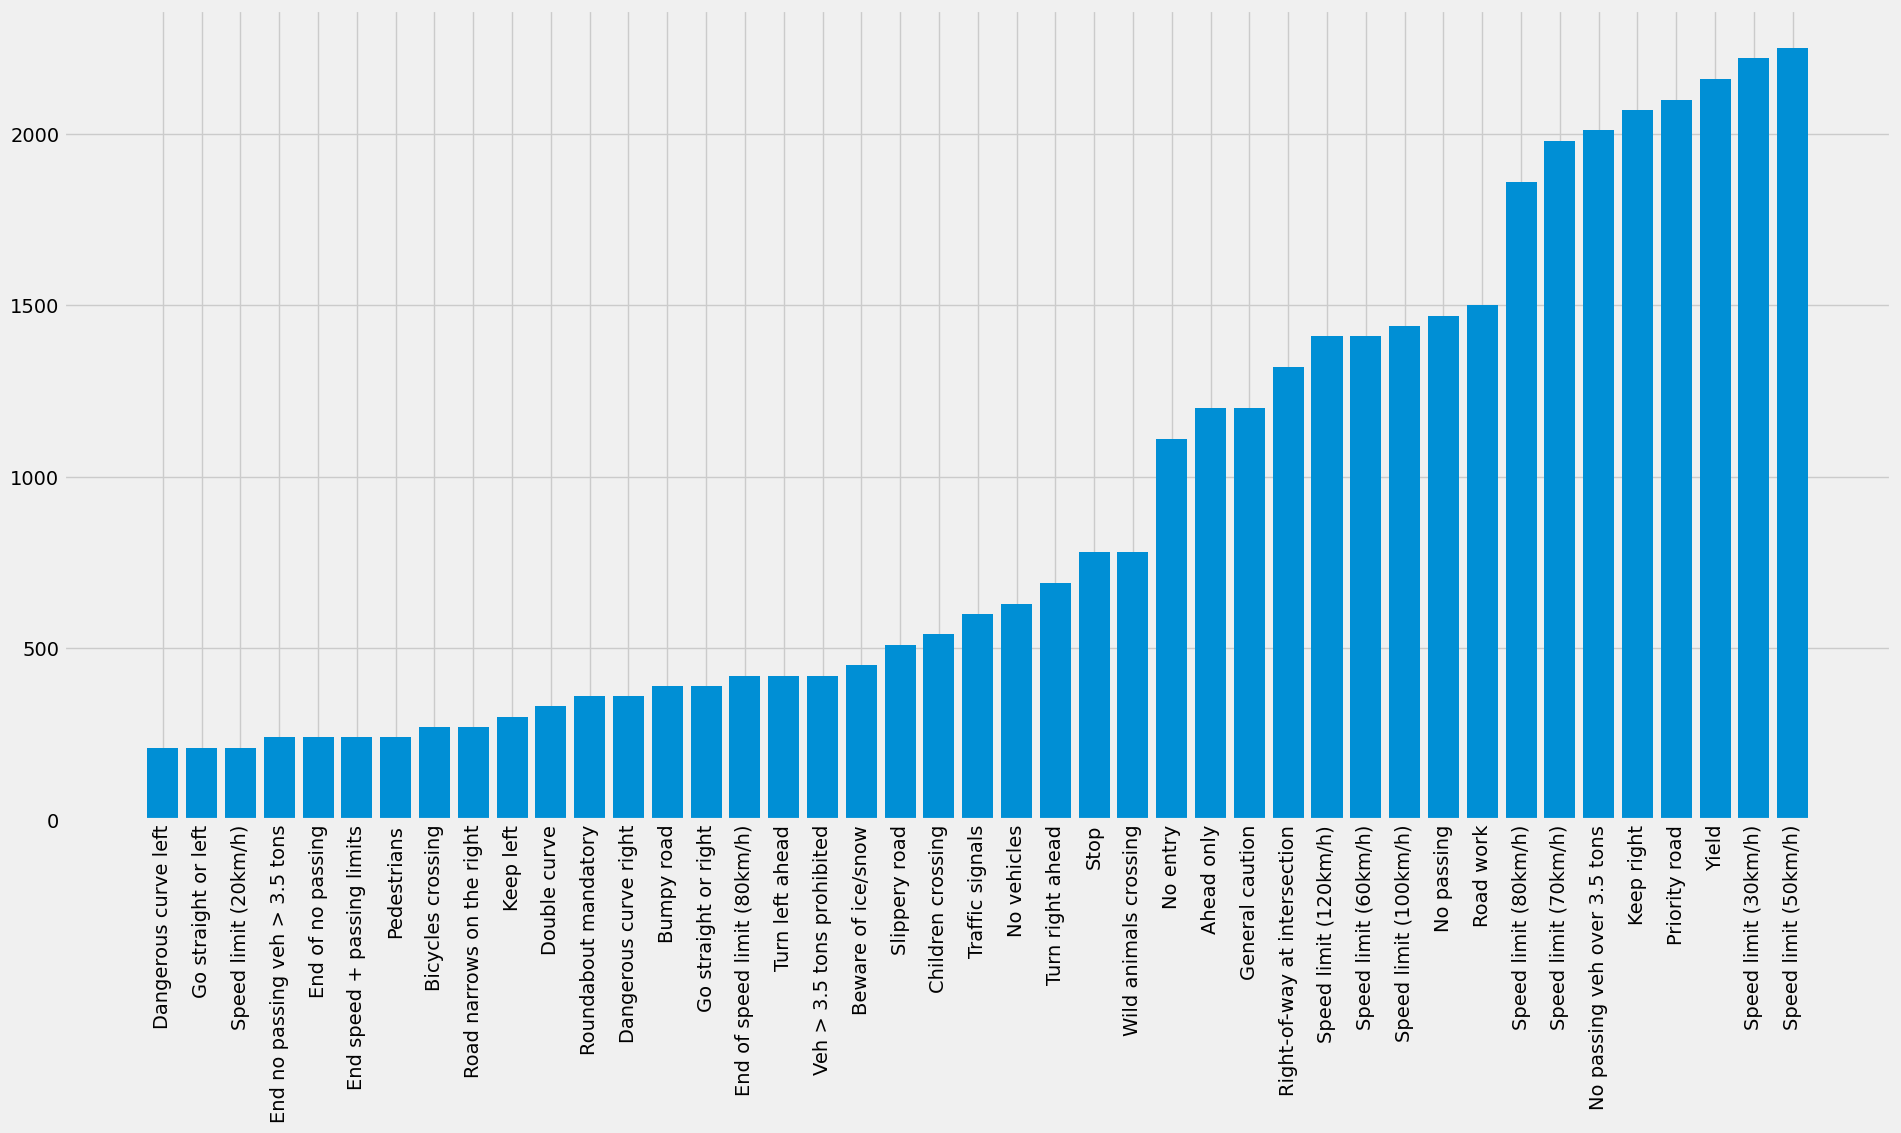

In [ ]:
folders = os.listdir('/content/gdrive/MyDrive/archive/Train') #os.listdir() 매써드는 지정한 디렉토리 내의 모든 파일과 디렉토리 리스트(list)를 리턴

train_num = []
class_num = []

for folder in folders:
  train_files = os.listdir(str(train_path) + '/'+ folder) #리스트로 가져오면 에러떠서 str로 변환해줌
  train_num.append(len(train_files))
  class_num.append(classes[int(folder)])

# 각각의 클래스의 이미지의 수에 기초해 데이터셋 분류하기
zipped_lists =  zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples =  zip(*sorted_pairs) # sorted(정렬할 데이터), 새로운 정렬된 리스트로 만들어서 반환
train_num, class_num = [ list(tuple) for tuple in tuples]

# 시각화
plt.figure(figsize = (21, 10))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [ ]:
def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(30, 30))
            image = img_to_array(img) # 이미지를 넘파이 배열로 변환
            images.append(image)
            labels.append(category)

    return images, labels

images, labels = load_data(train_path)

# labels에 원핫 인코딩 진행
labels = to_categorical(labels)

# 트레인, 테스트 셋 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.4)

In [ ]:
model = Sequential()

IMG_HEIGHT = 30
IMG_WIDTH = 30

# 첫번째 Convolutional Layer : 입력 데이터로부터 특징을 추출
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# 두번째 Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25)) # 인풋데이터의 25%를 무작위로 0으로 만듦

# 세번째 Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu')) # 특징을 추출하는 기능을 하는 필터, 비선형 값으로 바꿔주는 activation 함수->relu

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [ ]:
# Flattening the layer and adding Dense Layer
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [ ]:
# 모델 컴파일 하기
model.compile(
    loss='categorical_crossentropy', # 다중분류의 로스 함수
    optimizer='adam',
    metrics=['accuracy']
)

# 모델 핏하기
EPOCHS = 200
history = model.fit(x_train,
                    y_train,
                    validation_data = (x_test, y_test),
                    epochs=EPOCHS,
                    steps_per_epoch=60
                   )

Epoch 1/30
60/60 [==============================] - 9s 50ms/step - loss: 5.6238 - accuracy: 0.0492 - val_loss: 3.5599 - val_accuracy: 0.0627
Epoch 2/30
60/60 [==============================] - 2s 28ms/step - loss: 3.2556 - accuracy: 0.1730 - val_loss: 2.7359 - val_accuracy: 0.3314
Epoch 3/30
60/60 [==============================] - 2s 29ms/step - loss: 2.3634 - accuracy: 0.3779 - val_loss: 1.7232 - val_accuracy: 0.5449
Epoch 4/30
60/60 [==============================] - 2s 28ms/step - loss: 1.5121 - accuracy: 0.5611 - val_loss: 1.0676 - val_accuracy: 0.7189
Epoch 5/30
60/60 [==============================] - 2s 28ms/step - loss: 1.0429 - accuracy: 0.6915 - val_loss: 0.7130 - val_accuracy: 0.8243
Epoch 6/30
60/60 [==============================] - 2s 28ms/step - loss: 0.7626 - accuracy: 0.7756 - val_loss: 0.5066 - val_accuracy: 0.8750
Epoch 7/30
60/60 [==============================] - 2s 28ms/step - loss: 0.6103 - accuracy: 0.8236 - val_loss: 0.3885 - val_accuracy: 0.9062
Epoch 8/30
60

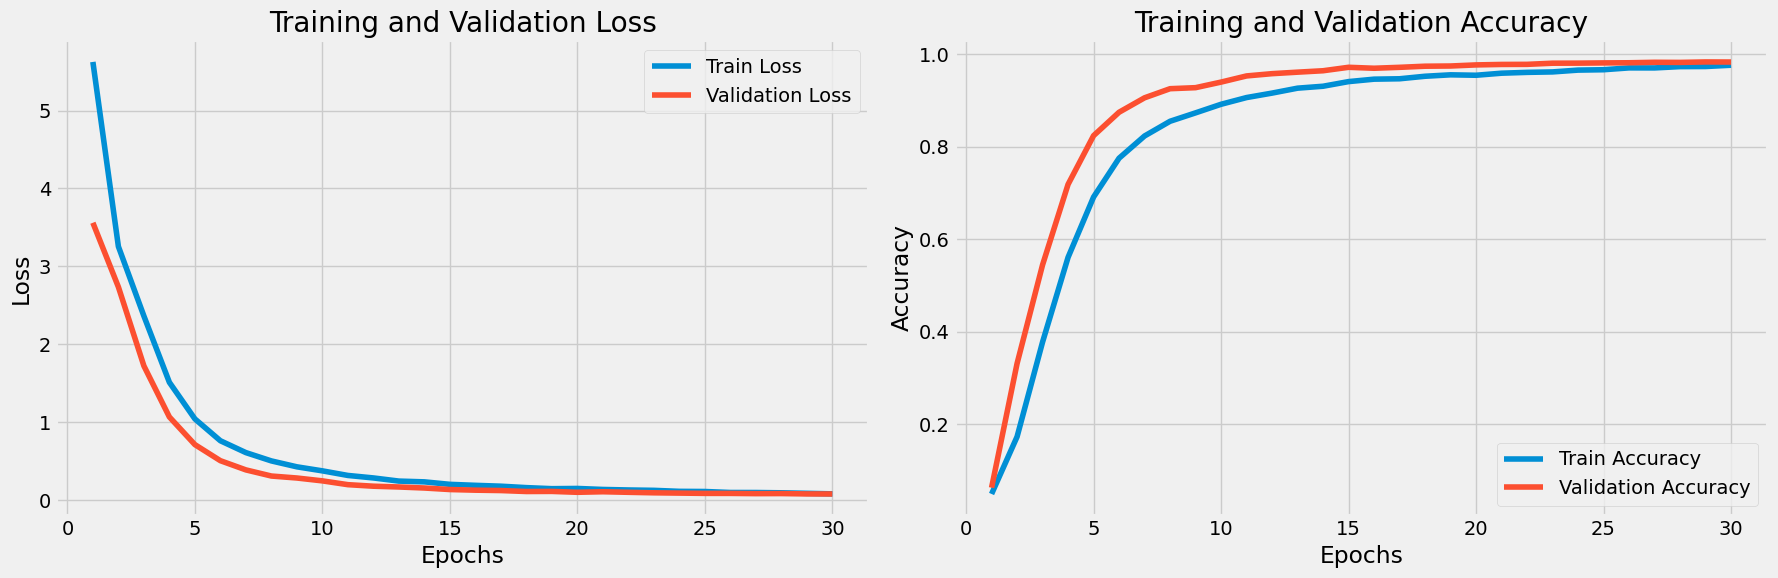

In [ ]:
import matplotlib.pyplot as plt

# 학습 결과 기록
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 손실 그래프
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_loss, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


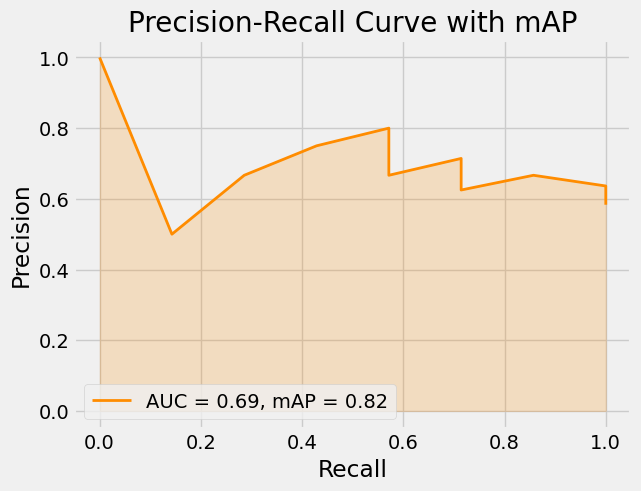

mAP (Mean Average Precision): 0.82


In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np
import matplotlib.pyplot as plt

def calculate_mAP(y_true, y_scores):
    average_precisions = []
    for class_idx in range(len(y_true[0])):
        class_true = y_true[:, class_idx]
        class_scores = y_scores[:, class_idx]
        average_precision = average_precision_score(class_true, class_scores)
        average_precisions.append(average_precision)

    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

def plot_precision_recall_curve_with_mAP(y_true, y_scores, title='Precision-Recall Curve with mAP'):
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_scores.ravel())
    area_under_curve = auc(recall, precision)

    mean_average_precision = calculate_mAP(y_true, y_scores)

    #plt.figure(figsize=(14, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC = {area_under_curve:.2f}, mAP = {mean_average_precision:.2f}')

    plt.fill_between(recall, precision, alpha=0.2, color='darkorange')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()

    print(f'mAP (Mean Average Precision): {mean_average_precision:.2f}')

# 예시: 실제 레이블과 모델의 예측 점수를 사용하여 Precision-Recall Curve와 mAP를 그림
y_true = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0], [0, 0, 1]])
y_scores = np.array([[0.1, 0.9, 0.8], [0.7, 0.6, 0.2], [0.3, 0.5, 0.9], [0.2, 0.4, 0.85]])

plot_precision_recall_curve_with_mAP(y_true, y_scores)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 1s 3ms/step - loss: 0.0794 - accuracy: 0.9836
test set accuracy:  98.36138486862183


491/491 [==============================] - 1s 2ms/step


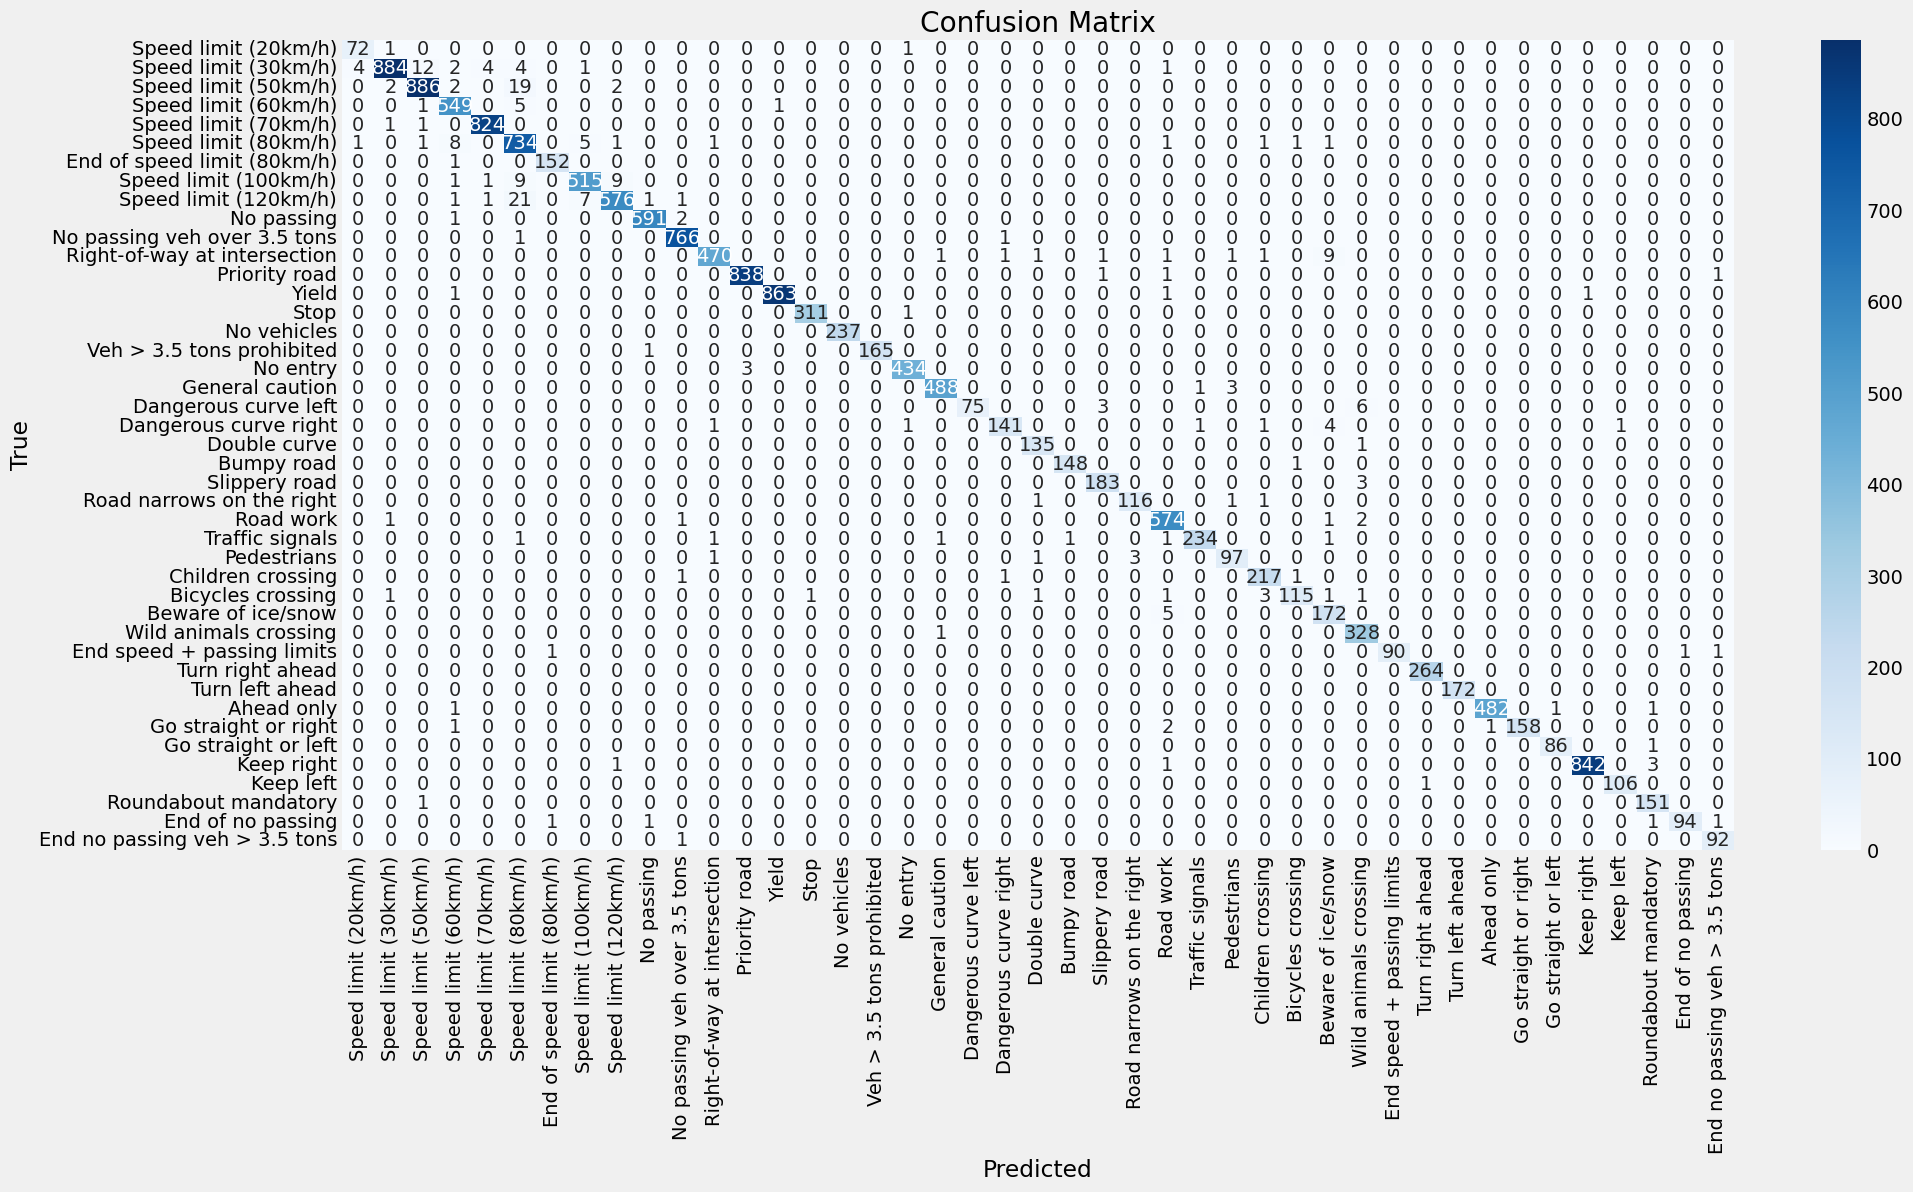


Classification Report:
                                precision    recall  f1-score   support

         Speed limit (20km/h)       0.94      0.97      0.95        74
         Speed limit (30km/h)       0.99      0.97      0.98       912
         Speed limit (50km/h)       0.98      0.97      0.98       911
         Speed limit (60km/h)       0.97      0.99      0.98       556
         Speed limit (70km/h)       0.99      1.00      1.00       826
         Speed limit (80km/h)       0.92      0.97      0.95       755
  End of speed limit (80km/h)       0.99      0.99      0.99       153
        Speed limit (100km/h)       0.98      0.96      0.97       535
        Speed limit (120km/h)       0.98      0.95      0.96       608
                   No passing       0.99      0.99      0.99       594
 No passing veh over 3.5 tons       0.99      1.00      0.99       768
 Right-of-way at intersection       0.99      0.97      0.98       486
                Priority road       1.00      1.00 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 예측
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report 출력
print('\nClassification Report:\n', classification_report(y_true, y_pred_classes, target_names=classes.values()))


In [ ]:
Y_test = pd.read_csv('/content/gdrive/MyDrive/archive/Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

a =  pathlib.Path('/content/gdrive/MyDrive/archive/')

output = list()
for img in test_images:
    image = load_img(os.path.join(a, img), target_size=(30, 30))
    output.append(np.array(image))

X_test=np.array(output)
y_prob = model.predict(X_test)
pred = y_prob.argmax(axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 1s 2ms/step
Test Data accuracy:  93.11163895486936


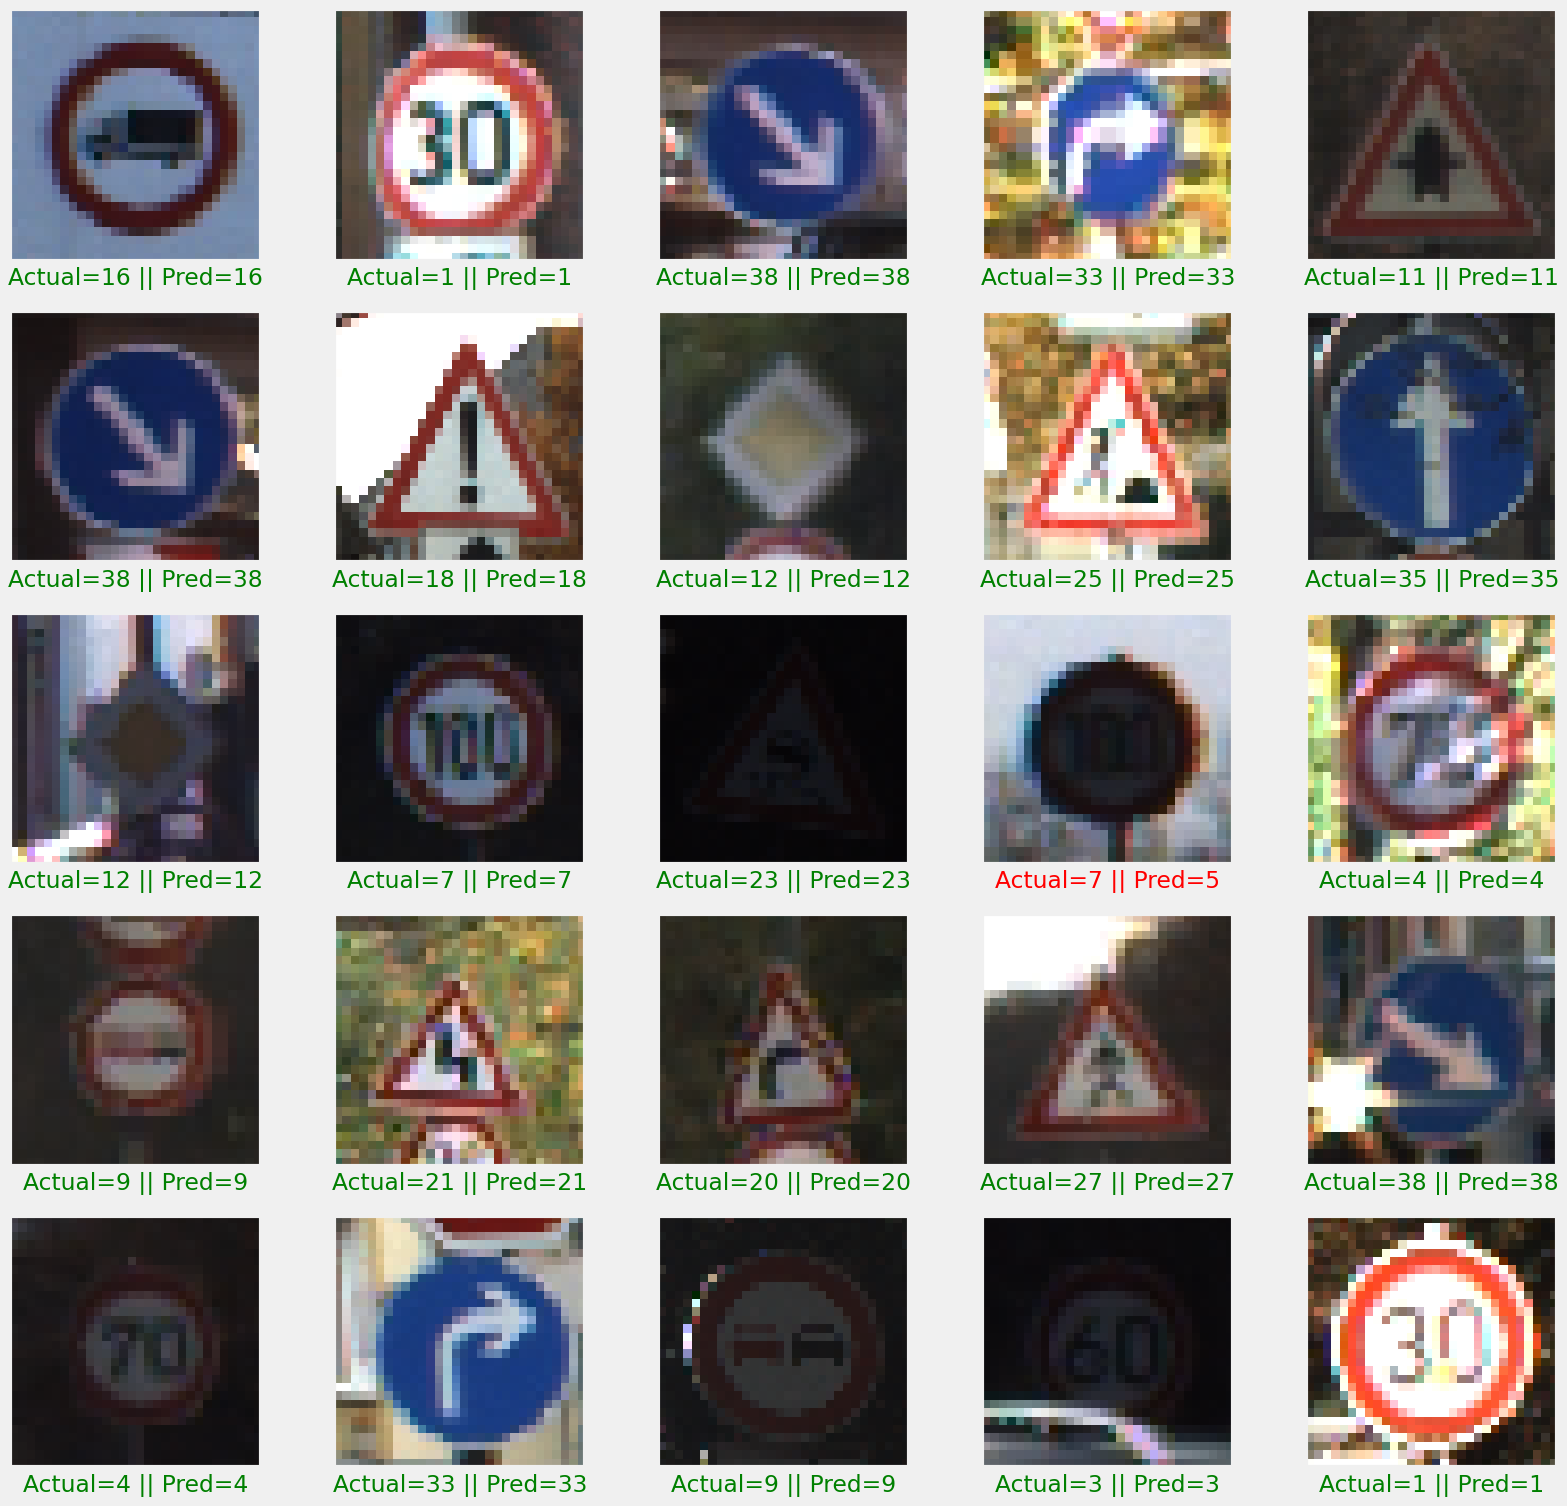

In [ ]:
plt.figure(figsize = (18, 18))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()